# Using Pitcher Hitter Catcher Model + Pose Estimation to Predict Intended Location

## Pre-work

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi ## works for
!lspci | grep -i nvidia

In [ ]:
!pip list

In [1]:
## IF you want to use virtual environments for your jupyter kernel,
## I recomend not running this cell and instead
## handling the clone + requirements install manually.

#!git clone https://github.com/dylandru/BaseballCV.git
%cd BaseballCV
#!pip install -r requirements.txt

## We also need to install other packages that will help us later that are not in reqs
#!pip install moviepy==1.0.3
#!pip install mediapip==0.10.15
#!pip install
#!pip install
#!pip install
#!pip install

/home/jd/Documents/GitHub/PublicNotebooks/BaseballCVNotebooks/BaseballCV


/home/jd/Documents/GitHub/PublicNotebooks/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Static Image

Creating an intended target from a static image is a lot simpler than with video. With video, you have to determine when the catcher is actually in his final receiving location and not just deaking the batter and/or setting a visual reference point for the pitcher. That will be covered in the following section.

In [2]:
##Import libraries
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import moviepy.editor as mpy
from scripts.load_tools import LoadTools
from scipy import stats
from IPython.display import Image
import os
import math
import statistics


# Initialize LoadTools class
load_tools = LoadTools()
load_tools.load_dataset("baseball_rubber_home_glove")  # can be any dataset within files

Dataset found at baseball_rubber_home_glove


'baseball_rubber_home_glove'

In [101]:
# you can choose any picture in any set
SOURCE_IMAGE_PATH = (
    "baseball_rubber_home_glove/baseball_rubber_home_glove/test/images/0009100.jpg"
)

In [13]:
## load pitcher catcher model
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)

## load glove model that includes plate,rubber, ball tracking, need glove, plate,rubber
model_weights_plate = load_tools.load_model(model_alias="glove_tracking")
model_plate = YOLO(model_weights_plate)

## you can save the image if you want. We will create a custom anotation
results_phc = model_phc.predict(source=SOURCE_IMAGE_PATH, save=False)
results_plate = model_plate.predict(source=SOURCE_IMAGE_PATH, save=False)



Model found at models/pitcher_hitter_catcher_detector/model_weights/pitcher_hitter_catcher_detector_v4.pt
Model found at models/glove_tracking/model_weights/glove_tracking.pt


NameError: name 'SOURCE_IMAGE_PATH' is not defined

In [3]:
## some helper functions to make later code cleaner
## simple slope / distance / endpoint functions

def slope_of_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x1 == x2:
        return None
    slope = (y2 - y1) / (x2 - x1)

    return slope


def find_endpoint(start_point, slope, length, visual=False):
    x1, y1 = start_point

    angle = math.atan(slope)

    delta_x = math.cos(angle) * length
    delta_y = math.sin(angle) * length

    x2 = x1 + delta_x
    y2 = y1 + delta_y
    if visual:
        return (int(x2), int(y2))
    else:
        return (x2, y2)


def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the Euclidean distance
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return distance


# assume that the intended zone is the weighted average of the catcher box
# default weights are
# glove is triple weighted in X
# catcher top is twice weighted with the rest being even
def intended_zone_pixles(x, y, wx=[1, 1, 3, 3], wy=[2, 1, 1, 1]):
    return (np.average(x, weights=wx), np.average(y, weights=wy))


def real_coordinates(izx,izy,plate):
    px1, py1, px2, py2 = plate.xyxy[0]
    px1, py1, px2, py2 = float(px1), float(py1), float(px2), float(py2)

    pw = abs(px1 - px2)
    height = abs(((izy - max([py1, py2])) * 17 / pw))
    side = ((izx - np.mean([px1, px2])) * 17 / pw)
    return (side,height)


def intended_zone(frame, model_phc, model_plate, catcher_depth=6):
    results_phc = model_phc.predict(source=frame, save=False, verbose=False)
    results_plate = model_plate.predict(source=frame, save=False, verbose=False)
    catcher = results_phc[0].boxes[
        torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]
    ]
    plate = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 1.0)[0].tolist()[0]
    ]
    rubber = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 3.0)[0].tolist()[0]
    ]
    glove = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 0.0)[0].tolist()[0]
    ]
    cx1, cy1, cx2, cy2 = catcher.xyxy[0]
    px1, py1, px2, py2 = plate.xyxy[0]
    rx1, ry1, rx2, ry2 = rubber.xyxy[0]
    gx1, gy1, gx2, gy2 = glove.xyxy[0]
    depth = abs(int(rx1) - int(rx2)) / 2 * 5 / 6

    izx, izy = intended_zone_pixles(
        x=[int(cx1), int(cx2), int(gx1), int(gx2)],
        y=[int(cy1), int(cy2), int(gy1), int(gy2)],
    )

    ground_line_slope = slope_of_line(
        (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
        (
            int(np.mean([int(rx1), int(rx2)])),
            int(np.mean([int(ry1), int(ry2)])) + int(depth),
        ),
    )

    catcher_beyond_pixlewidth = (
        distance_between_points(
            (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
            (
                int(np.mean([int(rx1), int(rx2)])),
                int(np.mean([int(ry1), int(ry2)])) + int(depth),
            ),
        )
        / 59.5
        * catcher_depth
    )
    translated = find_endpoint(
        (izx, izy), ground_line_slope, -1 * catcher_beyond_pixlewidth, visual=False
    )
    real_coords = real_coordinates(float(translated[0]), float(izy), plate)

    to_return = {
        "rawX": float(izx),
        "rawY": float(izy),
        "translatedX": float(translated[0]),
        "translatedY": float(translated[1]),
        "PlateLocSide": float(real_coords[0]),
        "PlateLocHeight": float(
            real_coords[1],
        ),
    }
    return to_return

In [104]:
## get the keypoints of the landmarks needed
catcher = results_phc[0].boxes[
    torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]
]
plate = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 1.0)[0].tolist()[0]
]
rubber = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 3.0)[0].tolist()[0]
]
glove = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 0.0)[0].tolist()[0]
]

cx1, cy1, cx2, cy2 = catcher.xyxy[0]
px1, py1, px2, py2 = plate.xyxy[0]
rx1, ry1, rx2, ry2 = rubber.xyxy[0]
gx1, gy1, gx2, gy2 = glove.xyxy[0]


# assume that the intended zone is the weighted average of the catcher box
# default weights are
# glove is triple weighted in X
# catcher box is 2 weighted in y


izx,izy =  intended_zone_pixles(x=[int(cx1), int(cx2), int(gx1), int(gx2)],
                            y=[int(cy1), int(cy2), int(gy1), int(gy2)])


In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape

cv2.line(
    image,
    (int(izx-10), int(izy)),
    (int(izx+10), int(izy)),
    (0, 215, 255),
    2,
)  # vertical target

cv2.line(
    image,
    (
        int(izx),
        int(izy-10),
    ),
    (int(izx), int(izy+10)),
    (0, 215, 255),
    2,
)  # horz target
cv2.putText(
    image,
    "Est Intended Catcher Target Zone",
    org=(
        int(izy),
        int(cy1),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 215, 255),  # White color
    thickness=2,
    lineType=cv2.LINE_AA,
)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

This puts the intended target AT the catcher. Since ball location is reported at plate crossing, we need to translate the catcher target location to the front of the plate. Lets Visualize what the difference is by extending the plate side to the catcher by utilizing the ground line between the rubber and the plate.

In [106]:
depth = abs(int(rx1) - int(rx2)) / 2 * 5 / 6
ground_line_slope = slope_of_line(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
)
catcher_beyond_pixlewidth = (
    distance_between_points(
        (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
        (
            int(np.mean([int(rx1), int(rx2)])),
            int(np.mean([int(ry1), int(ry2)])) + int(depth),
        ),
    )
    / 59.5
    * 6
)
translated = find_endpoint(
    (izx, izy), ground_line_slope, -1 * catcher_beyond_pixlewidth, visual=False
)

In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape
cx1, cy1, cx2, cy2 = catcher.xyxy[0]
px1, py1, px2, py2 = plate.xyxy[0]
rx1, ry1, rx2, ry2 = rubber.xyxy[0]
gx1, gy1, gx2, gy2 = glove.xyxy[0]
depth = abs(int(rx1) - int(rx2)) / 2 * 5 / 6

cv2.rectangle(image, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), 2)
cv2.rectangle(
    image, (int(rx1), int(ry1)), (int(rx2), int(ry2)), (0, 0, 255), 2
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory...
## Air Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (int(np.mean([int(rx1), int(rx2)])), int(np.mean([int(ry1), int(ry2)]))),
    (125, 0, 0),
    1,
)  # center plate to center rubber
# Ground Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
    (255, 0, 0),
    3,
)  # center plate to center rubber


### Vertical Plane
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), shape[0]),
    (int(np.mean([int(px1), int(px2)])), int(py2)),
    (255, 0, 0),
    2,
)  # center plate
cv2.line(
    image,
    (int(np.mean([int(rx1), int(rx2)])), shape[0]),
    (int(np.mean([int(rx1), int(rx2)])), int(ry2)),
    (255, 0, 0),
    2,
)  # center rubber


## assume catcher is 6 ft back from corner
# Step 1, get angle of ground line
ground_line_slope = slope_of_line(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
)

catcher_beyond_pixlewidth = distance_between_points(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
) / 59.5 * 6

endpoint_center = find_endpoint(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)

cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    endpoint_center,
    (255, 235, 0),
    2,
)  # center plate extend catcher

endpoint_firstbaseside = find_endpoint(
    (int(px1), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)
cv2.line(
    image,
    ((int(px1)), int(np.mean([int(py1), int(py2)]))),
    endpoint_firstbaseside,
    (255, 235, 0),
    2,
)  # left corner plate extend catcher
cv2.line(
    image,
    endpoint_firstbaseside,
    (endpoint_firstbaseside[0],0),
    (255, 235, 0),
    2,
)  # left corner plate extend catcher

endpoint_thirdbaseside = find_endpoint(
    (int(px2), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)
cv2.line(
    image,
    ((int(px2)), int(np.mean([int(py1), int(py2)]))),
    endpoint_thirdbaseside,
    (255, 235, 0),
    2,
)  # right corner plate extend catcher
cv2.line(
    image,
    endpoint_thirdbaseside,
    (endpoint_thirdbaseside[0], 0),
    (255, 235, 0),
    2,
)  # right corner plate extend catcher
cv2.line(
    image,
    (int(izx - 10), int(izy)),
    (int(izx + 10), int(izy)),
    (0, 215, 255),
    2,
)  # vertical target

cv2.line(
    image,
    (
        int(izx),
        int(izy - 10),
    ),
    (int(izx), int(izy + 10)),
    (0, 215, 255),
    2,
)  # horz target
translated = find_endpoint(
    (izx, izy), ground_line_slope, -1 * catcher_beyond_pixlewidth, visual=False
)
cv2.line(
    image,
    (int(translated[0] - 10), int(izy)),
    (int(translated[0] + 10), int(izy)),
    (255, 0, 255),
    2,
)  # vertical target

cv2.line(
    image,
    (
        int(translated[0]),
        int(izy - 10),
    ),
    (int(translated[0]), int(izy + 10)),
    (255, 0, 255),
    2,
)  # horz target

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

The cyan line is the strike zone projected onto the plane depth of the catcher a target. Now, the target (Gold) that looks middle of the plate is actually outside. This is what the angle of the camera does to our perception. Using the same translation, we can translate the intended location to the front of the plate (Purple).
Why don't we translate the y? Well its my dumb way of accounting for gravity. Unless you're throwing a riseball, in order to hit your catcher's target, the ball needs to cross the plate higher than the intended location. By leaving y unaffected by the translation, we can crudly account for this. 

In [ ]:
## Plate Loc Side and Plate Loc height in Inches of the Intended Target
real_coordinates(translated[0], izy, plate)


Now all you would have to do is match the ball flight data with the intended location and calculate the difference.

## Video

The added challenge of video stems from what frame to actually set the intended location? Catchers aren't monliths.

In [ ]:
## needed models
## load pitcher catcher model
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)

## load glove model that includes plate,rubber, ball tracking, need glove, plate,rubber
model_weights_plate = load_tools.load_model(model_alias="glove_tracking")
model_plate = YOLO(model_weights_plate)

In [4]:
### Lets use our function to create the indended zones over this mpv

SOURCE_VIDEO_PATH = "/home/jd/Downloads/liberatore.mp4"
output = "assets/result_first.mp4"

cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
# Get video properties (width, height, FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, fps, (frame_width, frame_height))
images = {}

for i in range(0,total_frames):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    try:
        intended_zone_resuls = intended_zone(np.copy(frame), model_phc=model_phc, model_plate=model_plate)
    except:
        intended_zone_resuls = {}
    if 'translatedX' in intended_zone_resuls.keys():
        cv2.line(
        frame,
        (
            int(intended_zone_resuls["translatedX"] - 10),
            int(intended_zone_resuls["rawY"]),
        ),
        (
            int(intended_zone_resuls["translatedX"] + 10),
            int(intended_zone_resuls["rawY"]),
        ),
        (255, 0, 255),
        4,
    )  # vertical target

        cv2.line(
        frame,
        (
            int(intended_zone_resuls["translatedX"]),
            int(intended_zone_resuls["rawY"] - 10),
        ),
        (
            int(intended_zone_resuls["translatedX"]),
            int(intended_zone_resuls["rawY"] + 10),
        ),
        (255, 0, 255),
        4,
    )  # horz target
        text = f"Est Plate Target: {int(intended_zone_resuls["PlateLocSide"])},{int(intended_zone_resuls["PlateLocHeight"])}"
        cv2.putText(
            frame,
            text,
            org=(
                int(intended_zone_resuls["rawX"]),
                int(intended_zone_resuls["rawY"]-100),
            ),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 0, 255),  # White color
            thickness=4,
            lineType=cv2.LINE_AA,
        )
    images[i] = frame
    out.write(frame)
cap.release()
out.release()

In [ ]:
video = mpy.VideoFileClip(output)
resized_video = video.resize((640, 360))  # Resize as needed
mpy.ipython_display(resized_video)

So, what location is the real location? When is the catcher actually at the location we need? Watching the video, we can see that at release the catcher moves to the spot we need. Now we need to create a way for us to determine release. We will use mediapipe's pose estimation to determine roughly when the pitcher releases the ball. 

In [14]:
## If you want an explainer of this code, I can do another notebook that breaks it down. For now, know 
## that it outputs the release frame number
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#### Create Detector, Set Options
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True,min_pose_detection_confidence = .5, min_tracking_confidence = .5,
      min_pose_presence_confidence = .5,)
detector = vision.PoseLandmarker.create_from_options(options)
mp_pose = mp.solutions.pose

def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in pose_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

def estimated_release_frame(xyz_dict):
    # get estimated throwing hand, if the range of RW is larger than LW then RW is the throwing hand (think about the rotation of the body)
    # if the right hand is covering more ground, its probably the throwing hand
    throw_hand = 'rw' if max(xyz_dict["rw"]['z']) - min(xyz_dict["rw"]['z']) > max(xyz_dict["lw"]['z']) - min(xyz_dict["lw"]['z']) else 'lw'
    glove_hand = 'lw' if throw_hand == 'rw' else 'rw'

    ## what frame does the arm reach maximam distance toward camera
    max_index = xyz_dict[throw_hand]['z'].index(min(xyz_dict[throw_hand]['z']))

    ## get points around key frame, our release is probably in here
    local_x_lw = xyz_dict[glove_hand]['x'][(max_index - 10) : (max_index + 10)]
    local_x_rw = xyz_dict[throw_hand]["x"][(max_index - 10) : (max_index + 10)]
    local_frame = xyz_dict["frame"][(max_index - 10) : (max_index + 10)]

    #get the max distance between wrists in x plane within this region
    max_distance = [abs(l - r) for l, r in zip(local_x_lw, local_x_rw)]

    ## assume release is the maximum distance between the wrists within the range we searched
    max_index = max_distance.index(max(max_distance))

    return local_frame[max_index]

model_phc = YOLO(load_tools.load_model("phc_detector"))
results_phc = model_phc.predict(source=SOURCE_VIDEO_PATH, save=False)
model_ball = YOLO(load_tools.load_model("ball_tracking"))

pitcher_frames = []
for result in results_phc:
    index = torch.where(result.boxes.cls == 1)[0].tolist()
    if index == []:
        pitcher_frames.append([])
    else:
        pitcher = result.boxes[index[0]]
        pitcher_frames.append(pitcher.xyxy[0])
## crop each frame and run mediapipe & ball tracker
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
pitcher_frames = []
xyz_dict = {key: {"x": [], "y": [], "z": []} for key in ["lw", "rw", "ls", "rs"]}
xyz_dict["frame"] = []
images = {}
i= 0
for result in results_phc:
    index = torch.where(result.boxes.cls == 1)[0].tolist()
    if index == []:
        i=i+1
        continue        
    else:
        pitcher = result.boxes[index[0]]
        x1, y1, x2, y2 = pitcher.xyxy[0]
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        cropped_image = frame[
            int(y1) : int(y2), int(x1) : int(x2)
        ]  # Note the order of dimensions (y, x)
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        mp_image_eval = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=cropped_image_rgb
        )
        detection_result = detector.detect(mp_image_eval)
        if len(detection_result.pose_landmarks) == 0:
            continue

        else:
            xyz_dict["lw"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].z
            )
            xyz_dict["rw"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].z
            )
            xyz_dict["ls"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].z
            )
            xyz_dict["rs"]["z"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].z
            )
            xyz_dict["lw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].x
            )
            xyz_dict["rw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].x
            )
            xyz_dict["ls"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].x
            )
            xyz_dict["rs"]["x"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].x
            )
            xyz_dict["lw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].y
            )
            xyz_dict["rw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].y
            )
            xyz_dict["ls"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].y
            )
            xyz_dict["rs"]["y"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].y
            )
            xyz_dict["frame"].append(i)
        i=i+1    
        images[i] = draw_landmarks_on_image(cropped_image_rgb, detection_result)
    

release_frame = estimated_release_frame(xyz_dict)


Model found at models/pitcher_hitter_catcher_detector/model_weights/pitcher_hitter_catcher_detector_v4.pt


I0000 00:00:1730087125.731127     522 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1730087125.780188     749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730087125.851180     749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/392) /home/jd/Downloads/liberatore.mp4: 480x800 2 hitters, 38.2ms
video 1/1 (frame 2/392) /home/jd/Downloads/liberatore.mp4: 480x800 1 hitter, 36.9ms
video 1/1 (frame 3/392) /home/jd/Downloads/liberatore.mp4: 480x800 2 hitters, 23.3ms
video 1/1 (frame 4/392) /home/jd/Downloads/liberatore.mp4: 480x800 2 hitters, 24.7ms
video 1/1 (frame 5/392) /home/jd/Downloads/liberatore.mp4: 480x800 1 hitter, 25.2ms
video 1/1 (frame 6/392) /home/jd/

In [ ]:
## lets check our assumptions
for image in images.keys():
    print(image)
    plt.imshow(images[image])
    plt.axis('off')
    plt.show()

Our method says that the intended location for this pitch will come at frame "release_frame". Below is the positon of the catcher at that point. That looks pretty close. 

In [ ]:
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, release_frame)
ret, staticframe = cap.read()
izr = intended_zone(staticframe, model_phc=model_phc, model_plate=model_plate)
frame_rgb = cv2.cvtColor(staticframe, cv2.COLOR_BGR2RGB)

cv2.line(
    frame_rgb,
    (
        int(izr["translatedX"] - 10),
        int(izr["rawY"]),
    ),
    (
        int(izr["translatedX"] + 10),
        int(izr["rawY"]),
    ),
    (255, 0, 255),
    4,
)  # vertical target

cv2.line(
    frame_rgb,
    (
        int(izr["translatedX"]),
        int(izr["rawY"] - 10),
    ),
    (
        int(izr["translatedX"]),
        int(izr["rawY"] + 10),
    ),
    (255, 0, 255),
    4,
)  # horz target
text = f"Est Plate Target: {int(izr["PlateLocSide"])}s,{int(izr["PlateLocHeight"])}h"
cv2.putText(
    frame_rgb,
    text,
    org=(
        int(izr["rawX"]),
        int(izr["rawY"] - 100),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(255, 0, 255),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)

plt.imshow(frame_rgb)
plt.axis('off')
plt.show()

Finally, we can put our intended location as a static image over the top of our mp4. 

In [115]:
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
# Get video properties (width, height, FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
output1 = "assets/result_second.mp4"

out = cv2.VideoWriter(output1, fourcc, fps, (frame_width, frame_height))
images = {}

for i in range(0, total_frames):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    cv2.line(
        frame,
        (
            int(izr["translatedX"] - 10),
            int(izr["rawY"]),
        ),
        (
            int(izr["translatedX"] + 10),
            int(izr["rawY"]),
        ),
        (255, 0, 255),
        4,
    )  # vertical target

    cv2.line(
        frame,
        (
            int(izr["translatedX"]),
            int(izr["rawY"] - 10),
        ),
        (
            int(izr["translatedX"]),
            int(izr["rawY"] + 10),
        ),
        (255, 0, 255),
        4,
    )  # horz target
    text = f"Est Plate Target: {int(izr["PlateLocSide"])}s,{int(izr["PlateLocHeight"])}h"
    cv2.putText(
        frame,
        text,
        org=(
            int(izr["rawX"]),
            int(izr["rawY"] - 100),
        ),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(255, 0, 255),  # White color
        thickness=4,
        lineType=cv2.LINE_AA,
    )
    images[i] = frame
    out.write(frame)
cap.release()
out.release()

In [ ]:
video = mpy.VideoFileClip(output1)
resized_video = video.resize((640, 360))  # Resize as needed
mpy.ipython_display(resized_video)

Same thing with image, we can use the trackman/hawkeye/ball flight data to match it up and estimate the miss distance!

In [32]:
import polars as pl

data = pl.read_csv("/home/jd/Downloads/processed_aggregates.csv")
lib = data.filter(pl.col("last_name, first_name") == "Liberatore, Matthew")

"last_name, first_name",player_id,team_name_alt,pitch_type,run_value_per_100,pitches,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand,release_speed,spin_rate,movement_inches,alan_active_spin_pct,active_spin,hawkeye_measured,movement_inferred,api_pitch_name,active_spin_formatted,hawkeye_measured_clock_minutes,movement_inferred_clock_minutes,diff_measured_inferred,diff2,diff_measured_inferred_minutes,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,pitcher_break_z,league_break_z,diff_z,rise,pitcher_break_z_induced,pitcher_break_x,league_break_x,diff_x,tail,percent_rank_diff_z,percent_rank_diff_x,ball_angle,relative_release_ball_x,release_ball_z,relative_shoulder_x,shoulder_z,translation,translated_relative_release_ball_x,translated_pitcher_break_x,ball_angle_zscore,translated_relative_release_ball_x_zscore,release_ball_z_zscore,expected_pitcher_break_x,expected_pitcher_break_z,expected_break_x_diff,expected_break_z_diff,expected_break_x_zscore,expected_break_z_zscore
str,i64,str,str,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,f64,f64,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,str,str,str,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Liberatore, Matthew""",669461,"""STL""","""SI""",-0.6,277,89,0.284,0.481,0.361,14.2,20.2,17.8,0.269,0.468,0.347,47.6,"""L""",95.4,2139,18.8,0.92503,0.913196,153.68417,133.123333,"""Sinker""",91,60,90,20.560837,20.560837,-30,1,0,1,30,0,30,"""1:00""","""1:30""","""-0H 30M""",16.4,-19.8,-3.4,-17,13.6,13.1,-14.0,-1.0,-7,0.142361,0.229167,45,1.603332,6.4416,-0.035526,4.789525,-1,-1.603332,-13.1,0.535639,0.488116,1.357544,-13.1,13.6,0.0,0.0,-0.015615,0.00231
"""Liberatore, Matthew""",669461,"""STL""","""SL""",1.1,374,116,0.185,0.25,0.232,38.4,29.3,21.5,0.216,0.293,0.253,32.4,"""L""",87.4,2705,4.7,0.203448,0.207688,254.304593,278.090987,"""Slider""",21,570,525,-23.786395,23.786395,45,9,30,8,45,0,45,"""9:30""","""8:45""","""+0H 45M""",34.9,-33.7,1.2,4,0.6,3.6,4.0,-0.4,-11,0.650943,0.468553,45,1.603332,6.4416,-0.035526,4.789525,-1,-1.603332,-3.6,0.535639,0.488116,1.357544,-2.775,1.275,-0.825,-0.675,-0.138828,-0.340584
"""Liberatore, Matthew""",669461,"""STL""","""FF""",-0.3,384,72,0.262,0.615,0.382,18.9,12.5,12.2,0.273,0.607,0.386,43.1,"""L""",94.7,2115,17.3,0.860988,0.951695,151.697936,154.911832,"""4-Seam Fastball""",95,60,765,-3.213896,3.213896,15,1,0,12,45,0,15,"""1:00""","""12:45""","""+0H 15M""",14.2,-13.8,-0.3,-2,16.3,7.0,-6.7,0.3,5,0.458937,0.504831,45,1.603332,6.4416,-0.035526,4.789525,-1,-1.603332,-7.0,0.535639,0.488116,1.357544,-5.95,16.575,-1.05,-0.275,-0.172432,-0.137387
"""Liberatore, Matthew""",669461,"""STL""","""FC""",-2.2,174,44,0.432,0.622,0.474,22.8,4.5,6.9,0.35,0.508,0.404,35.1,"""L""",91.4,2537,9.2,0.412846,0.46782,168.361089,192.389252,"""Cutter""",47,750,690,-24.028163,24.028163,60,12,30,11,30,1,0,"""12:30""","""11:30""","""+1H 00M""",22.9,-24.0,1.2,5,9.6,1.4,2.6,-1.2,-47,0.727273,0.290909,45,1.603332,6.4416,-0.035526,4.789525,-1,-1.603332,-1.4,0.535639,0.488116,1.357544,-0.9,10.133333,-0.5,-0.533333,-0.09029,-0.268618
"""Liberatore, Matthew""",669461,"""STL""","""CU""",-1.4,88,25,0.174,0.174,0.172,27.3,52.0,21.7,0.193,0.228,0.206,27.3,"""L""",78.2,2865,23.3,0.946409,0.919763,332.165534,333.143569,"""Curveball""",92,420,420,-0.978036,0.978036,0,7,0,7,0,0,0,"""7:00""","""7:00""",""" 0H 00M""",63.0,-55.4,7.5,14,-17.5,10.1,8.0,2.1,26,0.99061,0.732394,45,1.603332,6.4416,-0.035526,4.789525,-1,-1.603332,-10.1,0.535639,0.488116,1.357544,-8.866667,-13.6,-1.233333,-3.9,-0.199813,-1.978853


In [24]:
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, 180)
ret, frame = cap.read()
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

mp_image_eval = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image_eval)
detection_result

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4014550447463989, y=0.48896533250808716, z=0.15540657937526703, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.3997499346733093, y=0.4813627004623413, z=0.15117530524730682, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.397774875164032, y=0.4797126054763794, z=0.15115338563919067, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.39578062295913696, y=0.47812581062316895, z=0.15114901959896088, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.404116690158844, y=0.4848274886608124, z=0.1490231603384018, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.40559279918670654, y=0.48585909605026245, z=0.14894911646842957, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.4071192443370819, y=0.48672449588775635, z=0.14902976155281067, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.3915293216705322, y=0.4796064496040344, z=0.12464119493961334, visibility=1.0, presence=1.0), NormalizedLandmark(x=0.

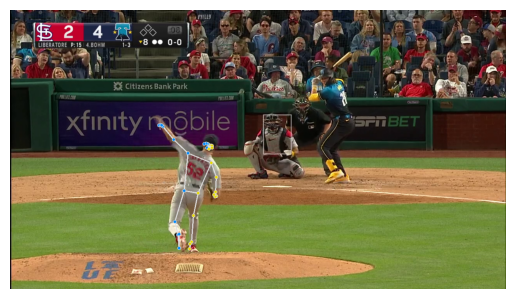

In [38]:
result = draw_landmarks_on_image(image_rgb, detection_result)
plt.imshow(result)
plt.axis("off")
plt.show()

In [25]:
pose_landmarks_list = detection_result.pose_landmarks
lw = pose_landmarks_list[0][mp_pose.PoseLandmark.LEFT_WRIST]
ls = pose_landmarks_list[0][mp_pose.PoseLandmark.RIGHT_SHOULDER]
wrist_x, wrist_y = lw.x, lw.y
shoulder_x, shoulder_y = ls.x, ls.y
dx = abs(wrist_x - shoulder_x)
dy = wrist_y - shoulder_y
angle_rad = np.arctan2(dy, dx)
angle_deg = abs(np.degrees(angle_rad))
angle_deg

53.18818579523228

In [34]:
##get plate
results_plate = model_plate.predict(source=result, save=False)
results_phc = model_phc.predict(source=result, save=False)

plate = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 1.0)[0].tolist()[0]
]
catcher = results_phc[0].boxes[
    torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]
]

cx1, cy1, cx2, cy2 = catcher.xyxy[0]
cx1, cy1, cx2, cy2 = float(cx1), float(cy1), float(cx2), float(cy2)

px1, py1, px2, py2 = plate.xyxy[0]
px1, py1, px2, py2 = float(px1), float(py1), float(px2), float(py2)

plate_pixel_inch = 17 / abs(px1 - px2)
x = np.mean([px1, px2])
y = np.mean([cy1, cy2])


0: 384x640 1 glove, 2 homeplates, 29.2ms
Speed: 20.4ms preprocess, 29.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x800 1 hitter, 1 catcher, 34.9ms
Speed: 1.4ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 800)


In [37]:
## Fourseam

lib .with_columns(
 pl.when(pl.col("pitch_hand") == "R")
    .then(1)
    .otherwise(-1)
    .alias("translation"))


lib = lib.with_columns(
    (
        (
            pl.col("pitcher_break_x")
            * pl.col("translation")
            * pl.col("break_translation")
            / plate_pixel_inch
        )
        + x
    ).alias("pitcher_pixel_x"),
    ((y - pl.col("pitcher_break_z_induced") / plate_pixel_inch)).alias(
        "pitcher_pixel_z"
    ),
    (
        (pl.col("expected_pitcher_break_x") * pl.col("translation") / plate_pixel_inch)
        + x
    ).alias("expected_pixel_x"),
    ((y - pl.col("expected_pitcher_break_z") / plate_pixel_inch)).alias(
        "expected_pixel_z"
    ),
)
lib

"last_name, first_name",player_id,team_name_alt,pitch_type,run_value_per_100,pitches,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand,release_speed,spin_rate,movement_inches,alan_active_spin_pct,active_spin,hawkeye_measured,movement_inferred,api_pitch_name,active_spin_formatted,hawkeye_measured_clock_minutes,movement_inferred_clock_minutes,diff_measured_inferred,diff2,diff_measured_inferred_minutes,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,pitcher_break_z,league_break_z,diff_z,rise,pitcher_break_z_induced,pitcher_break_x,league_break_x,diff_x,tail,percent_rank_diff_z,percent_rank_diff_x,ball_angle,relative_release_ball_x,release_ball_z,relative_shoulder_x,shoulder_z,translation,break_translation,translated_relative_release_ball_x,translated_pitcher_break_x,ball_angle_zscore,translated_relative_release_ball_x_zscore,release_ball_z_zscore,expected_pitcher_break_x,expected_pitcher_break_z,expected_break_x_diff,expected_break_z_diff,expected_break_x_zscore,expected_break_z_zscore,translated_expected_pitcher_break_x,pitcher_pixel_x,pitcher_pixel_z,expected_pixel_x,expected_pixel_z
str,i64,str,str,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,f64,f64,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,str,str,str,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Liberatore, Matthew""",669461,"""STL""","""SL""",1.1,374,116,0.185,0.25,0.232,38.4,29.3,21.5,0.216,0.293,0.253,32.4,"""L""",87.4,2705,4.7,0.203448,0.207688,254.304593,278.090987,"""Slider""",21,570,525,-23.786395,23.786395,45,9,30,8,45,0,45,"""9:30""","""8:45""","""+0H 45M""",34.9,-33.7,1.2,4,0.6,3.6,4.0,-0.4,-11,0.650943,0.468553,45,1.603332,6.4416,-0.035526,4.789525,-1,-1,-1.603332,-3.6,0.535639,0.488116,1.357544,-4.38,0.85,0.78,-0.25,0.266206,-0.076437,4.38,706.295561,346.844717,709.974298,345.665634
"""Liberatore, Matthew""",669461,"""STL""","""SI""",-0.6,277,89,0.284,0.481,0.361,14.2,20.2,17.8,0.269,0.468,0.347,47.6,"""L""",95.4,2139,18.8,0.92503,0.913196,153.68417,133.123333,"""Sinker""",91,60,90,20.560837,20.560837,-30,1,0,1,30,0,30,"""1:00""","""1:30""","""-0H 30M""",16.4,-19.8,-3.4,-17,13.6,13.1,-14.0,-1.0,-7,0.142361,0.229167,45,1.603332,6.4416,-0.035526,4.789525,-1,1,-1.603332,13.1,0.535639,0.488116,1.357544,14.52,10.32,-1.42,3.28,-0.515398,1.086188,-14.52,627.532848,285.532425,620.835659,301.001988
"""Liberatore, Matthew""",669461,"""STL""","""FC""",-2.2,174,44,0.432,0.622,0.474,22.8,4.5,6.9,0.35,0.508,0.404,35.1,"""L""",91.4,2537,9.2,0.412846,0.46782,168.361089,192.389252,"""Cutter""",47,750,690,-24.028163,24.028163,60,12,30,11,30,1,0,"""12:30""","""11:30""","""+1H 00M""",22.9,-24.0,1.2,5,9.6,1.4,2.6,-1.2,-47,0.727273,0.290909,45,1.603332,6.4416,-0.035526,4.789525,-1,-1,-1.603332,-1.4,0.535639,0.488116,1.357544,-2.25,8.16,0.85,1.44,0.291075,0.480174,2.25,695.919635,304.397745,699.928515,311.189261
"""Liberatore, Matthew""",669461,"""STL""","""FF""",-0.3,384,72,0.262,0.615,0.382,18.9,12.5,12.2,0.273,0.607,0.386,43.1,"""L""",94.7,2115,17.3,0.860988,0.951695,151.697936,154.911832,"""4-Seam Fastball""",95,60,765,-3.213896,3.213896,15,1,0,12,45,0,15,"""1:00""","""12:45""","""+0H 15M""",14.2,-13.8,-0.3,-2,16.3,7.0,-6.7,0.3,5,0.458937,0.504831,45,1.603332,6.4416,-0.035526,4.789525,-1,1,-1.603332,7.0,0.535639,0.488116,1.357544,7.25,16.27,-0.25,0.03,-0.099727,0.015783,-7.25,656.302462,272.798334,655.123379,272.939823
"""Liberatore, Matthew""",669461,"""STL""","""CU""",-1.4,88,25,0.174,0.174,0.172,27.3,52.0,21.7,0.193,0.228,0.206,27.3,"""L""",78.2,2865,23.3,0.946409,0.919763,332.165534,333.143569,"""Curveball""",92,420,420,-0.978036,0.978036,0,7,0,7,0,0,0,"""7:00""","""7:00""",""" 0H 00M""",63.0,-55.4,7.5,14,-17.5,10.1,8.0,2.1,26,0.99061,0.

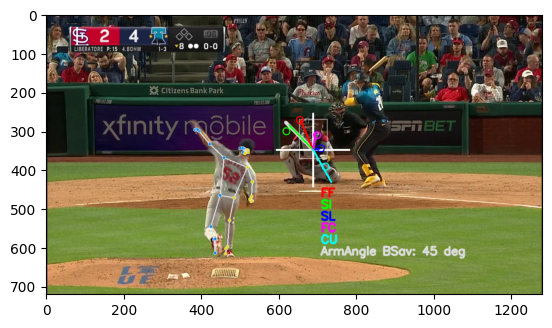

In [39]:
cv2.line(
    result,
    (
        int(x),
        int(y+20/plate_pixel_inch),
    ),
    (
        int(x),
        int(y-20/plate_pixel_inch),
    ),
    (255, 255, 255),
    4,
)  #baseline

cv2.line(
    result,
    (
        int(x + 20 / plate_pixel_inch),
        int(y),
    ),
    (
        int(x - 20 / plate_pixel_inch),
        int(y),
    ),
    (255, 255, 255),
    4,
)
## Arm Angle


delta_x = math.cos(np.radians(-1 * (45 + 90))) * 100
delta_y = math.sin(np.radians(-1 * (45 + 90))) * 100

x2 = int(x + delta_x)
y2 = int(y + delta_y)
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(x2),
        int(y2),
    ),
    (220, 220, 220),
    8,
)
cv2.putText(
    result,
    "ArmAngle BSav: 45 deg",
    org=(
        int(x + 20),
        int(y + 270),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(220, 220, 220),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)

##pitcher_pixel_x
##pitcher_pixel_z
##expected_pixel_x
##expected_pixel_z
## Fourseam
ff = lib.filter(pl.col('pitch_type') == 'FF')

# pitch
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(ff["pitcher_pixel_x"][0]),
        int(ff["pitcher_pixel_z"][0]),
    ),
    (255, 0, 0),
    4,
)
# expected
cv2.circle(
    result,
    (
        int(ff["expected_pixel_x"][0]),
        int(ff["expected_pixel_z"][0]),
    ),
    int(2 / plate_pixel_inch),
    (255, 0, 0),
    2,
)

## Sinker
si = lib.filter(pl.col("pitch_type") == "SI")

# pitch
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(si["pitcher_pixel_x"][0]),
        int(si["pitcher_pixel_z"][0]),
    ),
    (0, 255, 0),
    4,
)
# expected
cv2.circle(
    result,
    (
        int(si["expected_pixel_x"][0]),
        int(si["expected_pixel_z"][0]),
    ),
    int(2 / plate_pixel_inch),
    (0, 255, 0),
    2,
)
## SL
sl = lib.filter(pl.col("pitch_type") == "SL")

# pitch
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(sl["pitcher_pixel_x"][0]),
        int(sl["pitcher_pixel_z"][0]),
    ),
    (0, 0, 255),
    4,
)
# expected
cv2.circle(
    result,
    (
        int(sl["expected_pixel_x"][0]),
        int(sl["expected_pixel_z"][0]),
    ),
    int(2 / plate_pixel_inch),
    (0, 0, 255),
    2,
)
## FC
fc = lib.filter(pl.col("pitch_type") == "FC")

# pitch
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(fc["pitcher_pixel_x"][0]),
        int(fc["pitcher_pixel_z"][0]),
    ),
    (255, 0, 255),
    4,
)
# expected
cv2.circle(
    result,
    (
        int(fc["expected_pixel_x"][0]),
        int(fc["expected_pixel_z"][0]),
    ),
    int(2 / plate_pixel_inch),
    (255, 0, 255),
    2,
)
## CU
cu = lib.filter(pl.col("pitch_type") == "CU")

# pitch
cv2.line(
    result,
    (
        int(x),
        int(y),
    ),
    (
        int(cu["pitcher_pixel_x"][0]),
        int(cu["pitcher_pixel_z"][0]),
    ),
    (0, 255, 255),
    4,
)
# expected
cv2.circle(
    result,
    (
        int(cu["expected_pixel_x"][0]),
        int(cu["expected_pixel_z"][0]),
    ),
    int(2 / plate_pixel_inch),
    (0, 255, 255),
    2,
)

cv2.putText(
    result,
    "FF",
    org=(
        int(x + 20),
        int(y + 120),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(255, 0, 0),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)
cv2.putText(
    result,
    "SI",
    org=(
        int(x + 20),
        int(y + 150),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 255, 0),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)
cv2.putText(
    result,
    "SL",
    org=(
        int(x + 20),
        int(y + 180),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 0, 255),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)
cv2.putText(
    result,
    "FC",
    org=(
        int(x + 20),
        int(y + 210),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(255, 0, 255),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)
cv2.putText(
    result,
    "CU",
    org=(
        int(x + 20),
        int(y + 240),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 255, 255),  # White color
    thickness=4,
    lineType=cv2.LINE_AA,
)

plt.imshow(result)
plt.show()

In [40]:
image_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

cv2.imwrite("/home/jd/Downloads/lib_poseandbreak.jpg", image_rgb)

True